### **Libraries**

In [1]:
!pip install gym[atari,accept-rom-license]

INFO: pip is looking at multiple versions of gym[accept-rom-license,atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 26.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827726 sha256=4b765d6018d30d4be2fc83feb169339a23bd7712cb550edf8d41e2b433b4e22d
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_

In [2]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/bank_heist.bin
Inst

In [3]:
from gym.wrappers import AtariPreprocessing, FrameStack
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
import torch.optim as optim
import pandas as pd, time
from tqdm import trange
import torch.nn as nn
import numpy as np
import gym as gym
import torch
import json
import os

In [4]:
os.makedirs("results", exist_ok=True)

### **Environments**

In [5]:
env_name = "ALE/Adventure-v5"

### **Hyperparameters**

In [6]:
GAMMA = 0.99
LR = 3e-4
ENTROPY_COEF = 0.01
GAE_LAMBDA = 0.95
MAX_EPISODES = 10
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [7]:
np.random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
def set_env_seed(env, seed=SEED):
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

def plot_rewards(reward_dict):
    plt.figure(figsize=(10,6))
    for key, rewards in reward_dict.items():
        plt.plot(rewards, label=key)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Algorithm Comparison")
    plt.legend()
    plt.grid()
    plt.show()

def plot_live(rewards, title):
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(rewards, label='Reward')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()
    plt.show()

### **REINFORCE policy (continuous)**

In [ ]:
class PolicyREINFORCE(nn.Module):
    def __init__(self, input_shape, act_dim):
        super().__init__()
        c, h, w = input_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),  # [32, 20, 20]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # [64, 9, 9]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # [64, 7, 7]
            nn.ReLU(),
        )

        # compute conv output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out_size = int(np.prod(self.conv(dummy).shape[1:]))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, act_dim)
        )

    def forward(self, x):
        x = x / 255.0 if x.max() > 1.0 else x  
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

### **CNN encoder**

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        c, h, w = input_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out_size = int(np.prod(self.conv(dummy).shape[1:]))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
        )
        self.out_dim = 512

    def forward(self, x):
        x = x / 255.0 if x.max() > 1.0 else x
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### **A2C with separate networks**

In [11]:
class ActorCriticSeparate(nn.Module):
    def __init__(self, input_shape, act_dim):
        super().__init__()
        self.actor_encoder = CNNEncoder(input_shape)
        self.critic_encoder = CNNEncoder(input_shape)

        self.actor_head = nn.Linear(self.actor_encoder.out_dim, act_dim)
        self.critic_head = nn.Linear(self.critic_encoder.out_dim, 1)

    def forward(self, x):
        x_actor = self.actor_encoder(x)
        x_critic = self.critic_encoder(x)
        logits = self.actor_head(x_actor)
        value = self.critic_head(x_critic)
        return logits, value

### **A2C with shared network**

In [12]:
class ActorCriticShared(nn.Module):
    def __init__(self, input_shape, act_dim):
        super().__init__()
        self.shared = CNNEncoder(input_shape)
        self.actor_head = nn.Linear(self.shared.out_dim, act_dim)
        self.critic_head = nn.Linear(self.shared.out_dim, 1)

    def forward(self, x):
        feat = self.shared(x)
        logits = self.actor_head(feat)
        value = self.critic_head(feat)
        return logits, value

### **REINFORCE Training Loop**

In [ ]:
def train_reinforce(env_name):
    env = gym.make(env_name)
    env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=True, frame_skip=1)
    env = FrameStack(env, num_stack=4)
    set_env_seed(env)

    obs_shape = env.observation_space.shape 
    act_dim = env.action_space.n

    policy = PolicyREINFORCE(obs_shape, act_dim).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    metrics_list = []

    progress = trange(MAX_EPISODES, desc="REINFORCE", ncols=100)
    for ep in progress:
        state, _ = env.reset()
        log_probs, rewards = [], []
        done = False

        while not done:
            state_tensor = (
                torch.tensor(np.array(state), dtype=torch.float32)
                .unsqueeze(0)
                .to(DEVICE)
            )

            logits = policy(state_tensor)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            state = next_state

        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + GAMMA * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = 0
        for log_prob, R in zip(log_probs, returns):
            loss -= log_prob * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_reward = sum(rewards)
        progress.set_postfix_str(f"Reward: {ep_reward:.2f}")

        metrics_list.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "length": len(rewards)
        })

    env.close()
    df = pd.DataFrame(metrics_list)
    return df

### **A2C Training Loop (separate/shared, with optional GAE)**

In [ ]:
def train_a2c(env_name, variant="separate", use_gae=False):
    env = gym.make(env_name)
    env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=True, frame_skip=1)
    env = FrameStack(env, num_stack=4)
    set_env_seed(env)

    obs_shape = env.observation_space.shape  # (4, 84, 84)
    act_dim = env.action_space.n

    if variant == "separate":
        model = ActorCriticSeparate(obs_shape, act_dim)
    else:
        model = ActorCriticShared(obs_shape, act_dim)

    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    metrics_list = []

    progress = trange(MAX_EPISODES, desc=f"A2C-{variant}{'+GAE' if use_gae else ''}", ncols=100)
    for ep in progress:
        state, _ = env.reset()
        done = False

        log_probs, values, rewards, dones = [], [], [], []

        while not done:
            state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0).to(DEVICE)

            logits, value = model(state_tensor)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            log_probs.append(dist.log_prob(action))
            values.append(value.squeeze(0))  
            rewards.append(reward)
            dones.append(done)
            state = next_state

        values_pred = torch.cat(values).to(DEVICE)

        returns_list, advantages_list = [], []
        R, A = 0, 0
        values_tensor = torch.cat(values).squeeze().to(DEVICE)  

        for t in reversed(range(len(rewards))):
            mask = 1.0 - float(dones[t])
            if use_gae:
                next_value = values_tensor[t + 1] if t + 1 < len(values_tensor) else 0
                delta = rewards[t] + GAMMA * next_value * mask - values_tensor[t]
                A = delta + GAMMA * GAE_LAMBDA * mask * A
                advantages_list.insert(0, A)
            R = rewards[t] + GAMMA * R * mask
            returns_list.insert(0, R)

        returns = torch.tensor(returns_list, dtype=torch.float32, device=DEVICE)
        advantages = (
            torch.tensor(advantages_list, dtype=torch.float32, device=DEVICE)
            if use_gae
            else returns - values_tensor
        )


        # losses
        values_pred = torch.cat(values).squeeze().to(DEVICE)
        actor_loss = -torch.stack([lp * adv for lp, adv in zip(log_probs, advantages)]).mean()
        critic_loss = ((returns - values_pred) ** 2).mean()
        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_reward = sum(rewards)
        progress.set_postfix_str(f"Reward: {ep_reward:.2f}")

        metrics_list.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "length": len(rewards)
        })

    env.close()
    return pd.DataFrame(metrics_list)

### **Clasicc Control Env**

In [15]:
results = {}
metrics = {
    "REINFORCE": {},
    "A2C_separate": {},
    "A2C_shared": {},
    "A2C_shared_GAE": {}
}

In [16]:
print(f"\n=== Training on: {env_name} ===")


=== Training on: ALE/Adventure-v5 ===


In [ ]:
# REINFORCE
df_reinforce = train_reinforce(env_name) 
metrics["REINFORCE"] = df_reinforce
df_reinforce.to_csv(f"results/REINFORCE_atari.csv", index=False)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
REINFORCE: 100%|██████████████████████████████████████| 10/10 [08:19<00:00, 49.96s/it, Reward: 0.00]


In [ ]:
# A2C Separate
df_a2c_sep = train_a2c(env_name, variant="separate")
metrics["A2C_separate"] = df_a2c_sep
df_a2c_sep.to_csv(f"results/A2C_separate_atari.csv", index=False)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
A2C-separate: 100%|███████████████████████████████████| 10/10 [12:25<00:00, 74.53s/it, Reward: 0.00]


In [ ]:
# A2C Shared
df_a2c_shared = train_a2c(env_name, variant="shared")
metrics["A2C_shared"] = df_a2c_shared
df_a2c_shared.to_csv(f"results/A2C_shared_atari.csv", index=False)

A2C-shared: 100%|█████████████████████████████████████| 10/10 [11:30<00:00, 69.07s/it, Reward: 0.00]


In [ ]:
# A2C Shared + GAE
df_a2c_shared_gae = train_a2c(env_name, variant="shared", use_gae=True)
metrics["A2C_shared_GAE"] = df_a2c_shared_gae
df_a2c_shared_gae.to_csv(f"results/A2C_shared_GAE_atari.csv", index=False)

A2C-shared+GAE: 100%|█████████████████████████████████| 10/10 [08:58<00:00, 53.84s/it, Reward: 0.00]


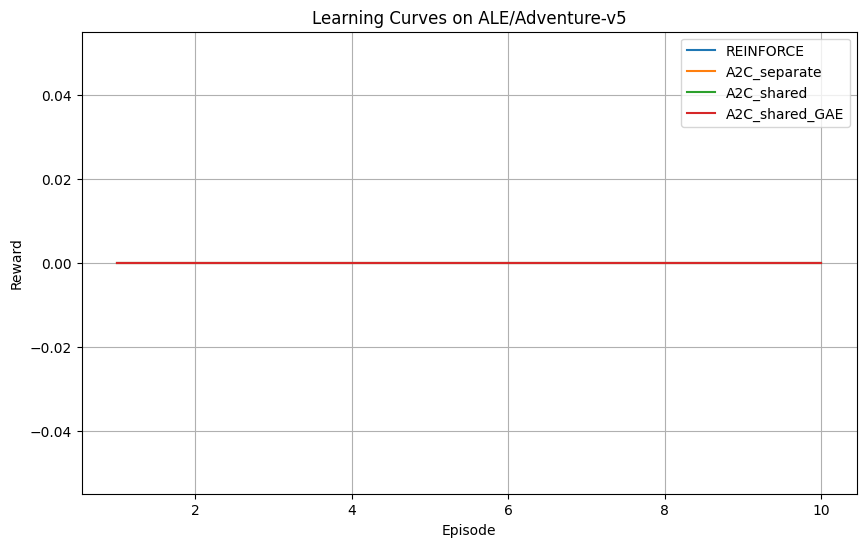

In [ ]:
plt.figure(figsize=(10,6))

for algo in ["REINFORCE", "A2C_separate", "A2C_shared", "A2C_shared_GAE"]:
    df = metrics[algo]
    plt.plot(df['episode'], df['reward'], label=algo)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Learning Curves on {env_name}")
plt.legend()
plt.grid(True)
plt.show()